<a id='Top'></a>

# Data Storytelling


                                                   By: Jun Ho Lee
                                                   
___


**NOTE**: NOT GOING TO USE PLOTLY + ipywidgets because they are not rendered online!

References: 

[Datacamp H1B_Dataset Example](https://www.datacamp.com/community/tutorials/predicting-H-1B-visa-status-python)  
[H1B Wage Distribution - Kaggle](https://www.kaggle.com/javidimail/h-1b-wage-distribution)  
[H1B Project - Independent Website](https://webpages.uncc.edu/sshinde5/)

<a id='Table of Contents'></a>
## Table of Contents

1. <a href='#Import Dataset'>Importing the Cleaned Dataset</a>
2. <a href='#Interactivity Introduction'>Introducing Interactivity with Plotly</a>


<a href='#Top'>Back to Top</a>

<a id='Import Dataset'></a>
____
### 1. Importing the Cleaned Dataset

Using the cleaned parameters saved in JSON format, we will load in the cleaned dataset that was saved from the previous notebook. 



**A. Import Necessary Libraries:**


In [10]:
import math
import itertools
from collections import Counter
import numpy as np
import pandas as pd
import scipy.stats as ss
import json
import matplotlib.pyplot as plt
import seaborn as sns
# # set option to see all the columns
pd.set_option('display.max_columns', 50)

# # suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)


**B. Read in JSON file to extract parameters:**

In [2]:
# Import JSON file for column information extraction 

with open('../data/H-1B_Feature_Creation_Cleaned_Params.json', 'r') as fp:
    h1b_params = json.load(fp)

final_cols = h1b_params['final_cols']
column_types = h1b_params['col_types']
date_columns = h1b_params['date_cols']

**C. Read in csv file**

In [3]:
h1b_df = pd.read_csv("../data/H-1B_Feature_Creation_Clean.csv", usecols = final_cols, dtype=column_types, low_memory=False, parse_dates=date_columns, infer_datetime_format=True)

**D. Verify Memory Usage and column data types**

In [4]:
# # Memory Usage 
# h1b_df.info(memory_usage='deep')

# # Columns
# h1b_df.columns

# # Column dtypes
# h1b_df.dtypes

<a href='#Table of Contents'>Back to Table of Contents</a>

<a id='Introduction'></a>
____
### 1. Introduction

Our final objective for this project is to correctly predict the `CASE_STATUS` of the applicant, making this project a classification problem. Thus `CASE_STATUS` will be our target variable and all other columns will be our feature variables. Currently there are 22 total columns in the dataset, leaving 21 feature variables for this dataset. There are however columns with redundant information (ex: `EMPLOYER_POSTAL_CODE` and `EMPLOYER_STATE_MAPPED`) and columns derived from other columns (ex: `PW_YEARLY_CONVERTED` from `PREVAILING_WAGE`). Thus feature engineering is necessary. 

As a first step however, I will investigate the distribution of our target variable: `CASE_STATUS`.



**- Pie Chart of Different Case Statuses**

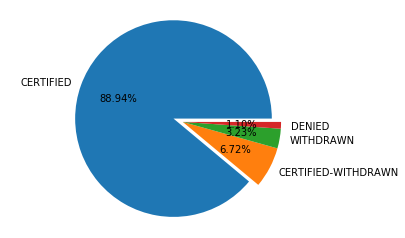

In [5]:
pie_chart_norm = h1b_df.CASE_STATUS.value_counts(normalize=True)
pie_chart_counts = h1b_df.CASE_STATUS.value_counts()

# # Pie Chart Plotting
fig, ax = plt.subplots()  # always use object oriented approach for plotting! 
                          # By default, plt.subplots(nrows=1, ncols=1)

explode = (0.1, 0, 0, 0)  # offset the first pie
ax.pie(pie_chart_norm, labels=pie_chart_norm.index, explode=explode, autopct='%1.2f%%')
ax.axis('equal') 
plt.show()

References:   
[Axes.pie - plt docs](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.pie.html)  
[Basic Pie Chart - plt demo](https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html#sphx-glr-gallery-pie-and-polar-charts-pie-features-py)  


Currently there are four different classes: 

1. CERTIFIED 
2. CERTIFIED-WITHDRAWN 
3. WITHDRAWN
4. DENIED 

and it looks like the data is heavily imbalanced, with Certified applicants taking up more than 85% of the whole dataset. However we are only interested in whether the applicant was certified or denied. So let's drop rows with `CERTIFIED-WITHDRAWN` or `WITHDRAWN`, making this classification a binary problem. This will make the dataset more imbalanced but we will be downsampling accordingly at the machine learning stage. 

**- Drop withdrawn / certified-withdrawn classes and make a new pie chart**

In [6]:
# # Make a copy of the original dataframe first (data_viz)
h1b_dviz = h1b_df.copy()

# # Change dtype (for CASE_STATUS only) to string because working with categoricals is hard
h1b_dviz['CASE_STATUS'] = h1b_dviz.CASE_STATUS.astype(str)

In [7]:
# # Drop the rows by index and reset index
wd_idx = h1b_dviz[h1b_dviz.CASE_STATUS == 'WITHDRAWN'].index
cert_wd_idx = h1b_dviz[h1b_dviz.CASE_STATUS == 'CERTIFIED-WITHDRAWN'].index
drop_idx = list(wd_idx) + list(cert_wd_idx)
h1b_dviz = h1b_dviz.drop(drop_idx)
h1b_dviz_clean = h1b_dviz.reset_index(drop=True)

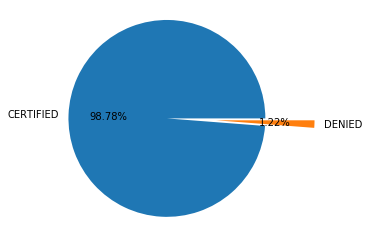

In [8]:
# # Making Pie Chart from the modified dataframe
ml_pie_chart_norm = h1b_dviz_clean.CASE_STATUS.value_counts(normalize=True)
ml_pie_chart_counts = h1b_dviz_clean.CASE_STATUS.value_counts()

# # Pie Chart Plotting
fig, ax = plt.subplots()  # always use object oriented approach for plotting! 
                          # By default, plt.subplots(nrows=1, ncols=1)

explode = (0, 0.5)  # offset the first pie
ax.pie(ml_pie_chart_norm, labels=ml_pie_chart_norm.index, explode=explode, autopct='%1.2f%%')
ax.axis('equal') 
plt.show()

Although the percentage of `CERTIFIED` class increased significantly, the `DENIED` class also rose a little bit - from 1.10% to 1.22%. The dataset however is still very imbalanced. 

<a id='Feature Creation'></a>
____
### 2. Feature Selection / Creation

For machine learning algorithms to perform well and be generalizable, a single feature shouldn't have too may factors. Using ***ipywidgets*** interactivity feature, we will quickly look through each categorical column to see how many *unique* values each column (feature) has and the *value_counts* of that column.

- Already did this step in Unit 5.5 (Feature Selection) 


<a href='#Table of Contents'>Back to Table of Contents</a>

### 3 Downsampling the data 

In [11]:
certified_df = h1b_dviz_clean[h1b_dviz_clean.CASE_STATUS == 'CERTIFIED']
denied_df = h1b_dviz_clean[h1b_dviz_clean.CASE_STATUS == 'DENIED']

In [12]:
print(certified_df.shape)
print(denied_df.shape)

(547402, 22)
(6787, 22)


In [14]:
sample_certified = certified_df.sample(n=6787, random_state=1)
sample_certified.shape

(6787, 22)

In [15]:
combined_total = pd.concat([sample_certified, denied_df])
combined_total.shape

(13574, 22)

Text(0.5, 1.0, 'Data Distribution after Downsampling')

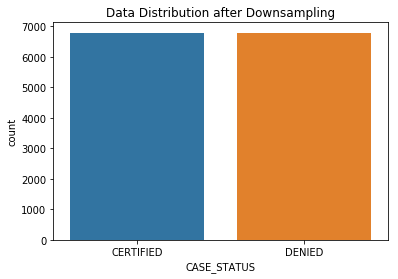

In [17]:
sns.countplot(x='CASE_STATUS', data=combined_total)
plt.title("Data Distribution after Downsampling")

<a id='Theils U'></a>
____
### 3. Cramers'V to find the correlation across categorical variables 

[Source: Kaggle Kernel (by shakedzy)](https://www.kaggle.com/shakedzy/alone-in-the-woods-using-theil-s-u-for-survival)


### Cramers V

In [18]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

#### Using the downsampled dataset

In [20]:
cols_final = ['CASE_STATUS',
 'VISA_CLASS',
 'EMPLOYER_STATE_MAPPED',
 'AGENT_REPRESENTING_EMPLOYER',
 'FULL_TIME_POSITION',
 'PW_UNIT_OF_PAY',
 'PW_WAGE_LEVEL',
 'WAGE_UNIT_OF_PAY',
 'H1B_DEPENDENT',
 'WILLFUL_VIOLATOR',
 'WORKSITE_STATE',
 'SOC_MAJOR_GROUP',
 'NAICS_BROAD']

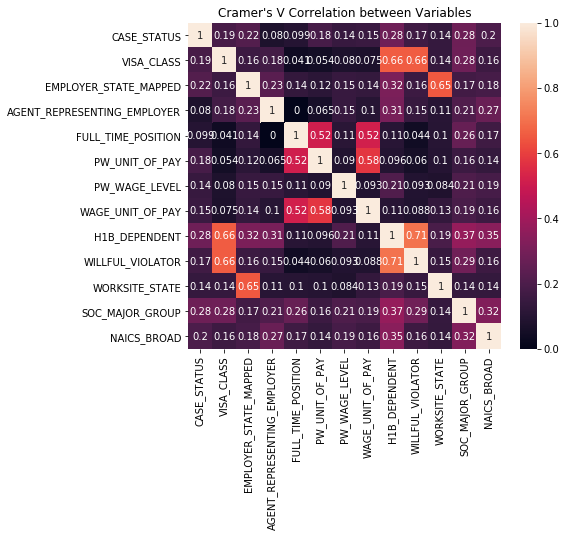

In [21]:
cols = cols_final

corrM = np.ones((len(cols),len(cols)))
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_v(combined_total[col1], combined_total[col2])
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer's V Correlation between Variables");

Looks like `CASE_STATUS` target is correlated with `VISA_CLASS` / `EMPLOYER_STATE` / `H1B_DEPENDENT` / `SOC_MAJOR_GROUP` / `NAICS_BROAD` columns

### VISA CLASS vs CASE_STATUS 

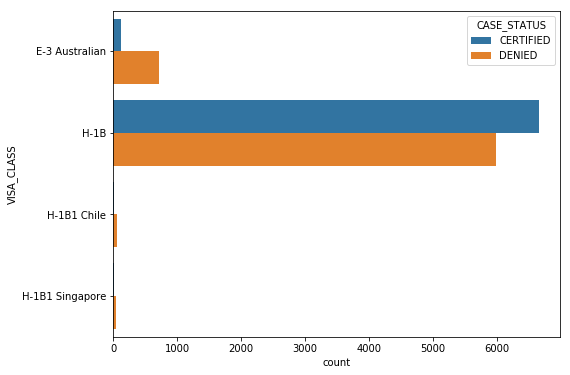

In [80]:

# # Showing only the top 15! (with order=)
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(y="VISA_CLASS", hue="CASE_STATUS", data=combined_total)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

### EMPLOYER_STATE vs CASE_STATUS 
- top 15 states by number of total submissions 

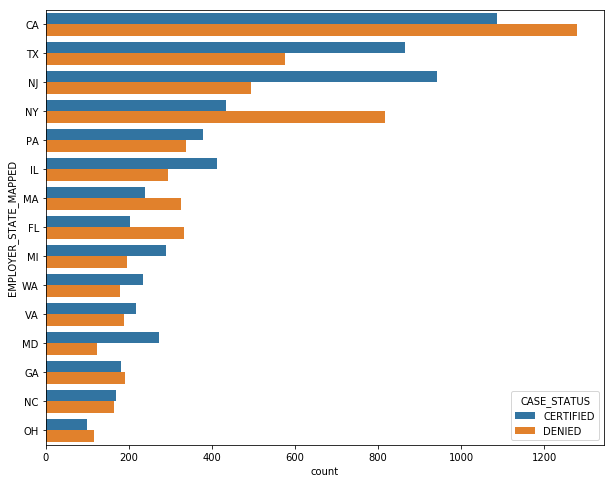

In [23]:

# # Showing only the top 15! (with order=)
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.countplot(y="EMPLOYER_STATE_MAPPED", hue="CASE_STATUS", order=combined_total.EMPLOYER_STATE_MAPPED.value_counts().iloc[:15].index, data=combined_total)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

### EMPLOYER_STATE vs CASE_STATUS 
- bottom 15 states by number of total submissions 
- notice the axis range! (very small) 

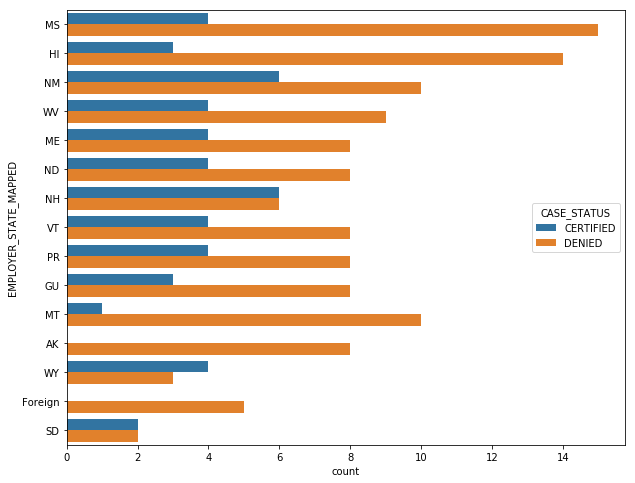

In [28]:

# # Showing only the top 15! (with order=)
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.countplot(y="EMPLOYER_STATE_MAPPED", hue="CASE_STATUS", order=combined_total.EMPLOYER_STATE_MAPPED.value_counts().iloc[-15:].index, data=combined_total)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

### SOC_MAJOR_GROUP vs CASE_STATUS 

- top 12

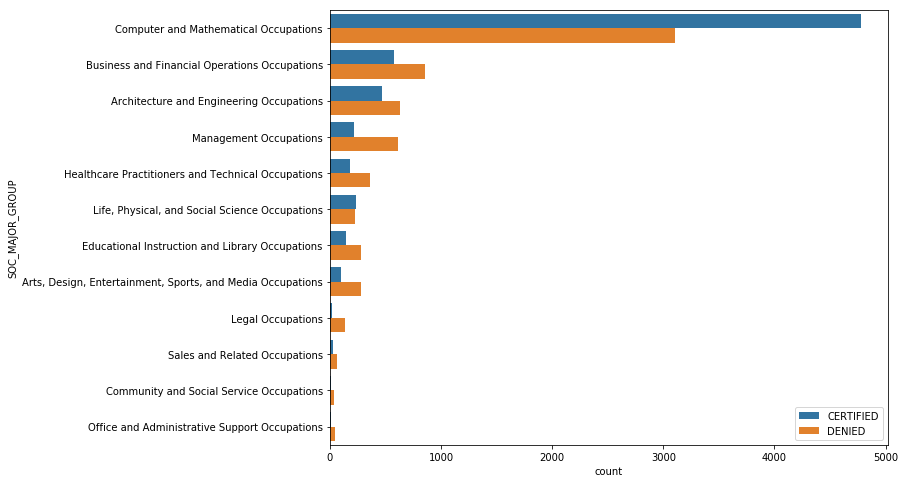

In [77]:
# # Plotting the top 12
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.countplot(y="SOC_MAJOR_GROUP", hue="CASE_STATUS", order=combined_total.SOC_MAJOR_GROUP.value_counts().iloc[:12].index, data=combined_total)
ax.legend(loc='lower right')
plt.show()

#### Remaining (13 groups)

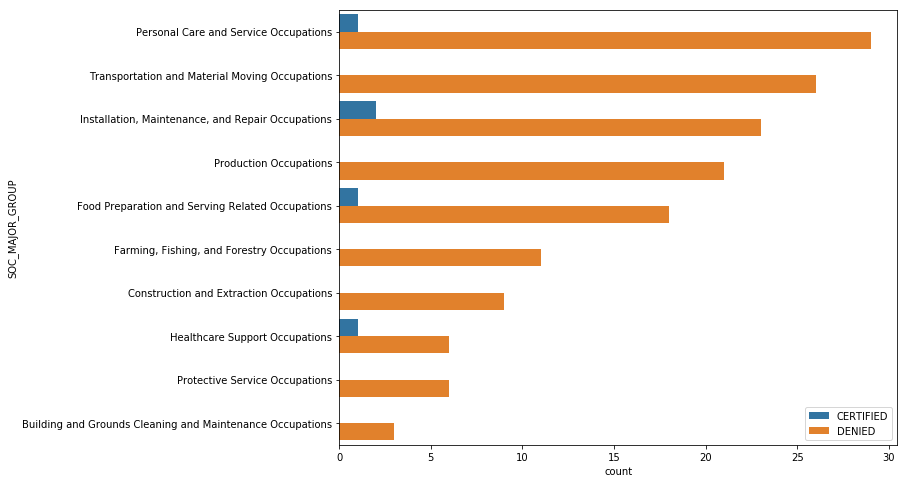

In [78]:
# # Plotting the remaining
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.countplot(y="SOC_MAJOR_GROUP", hue="CASE_STATUS", order=combined_total.SOC_MAJOR_GROUP.value_counts().iloc[12:].index, data=combined_total)
ax.legend(loc='lower right')
plt.show()

### H1B_DEPENDENT vs CASE_STATUS 


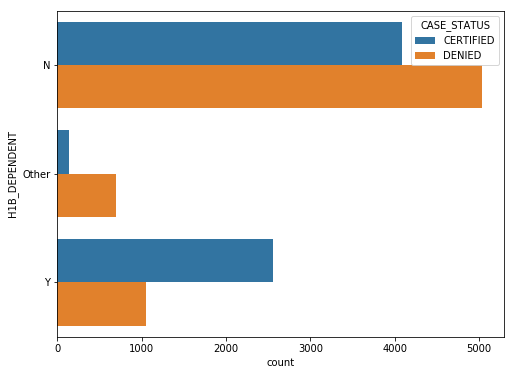

In [29]:

# # Showing only the top 15! (with order=)
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(y="H1B_DEPENDENT", hue="CASE_STATUS", data=combined_total)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

### UNIT_OF_PAY vs CASE_STATUS 


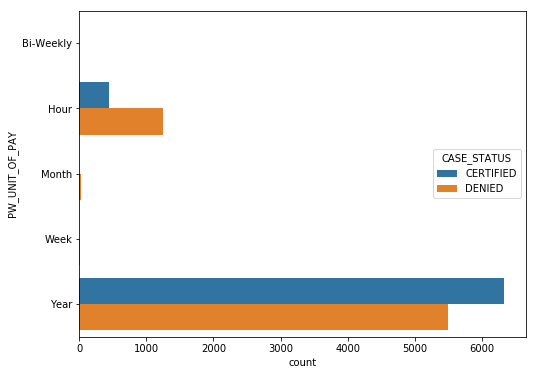

In [30]:

fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(y="PW_UNIT_OF_PAY", hue="CASE_STATUS", data=combined_total)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

### University Names  + Categorizing by Employer Names 

1. Academia (contains -> university)
2. FANG Companies (Facebook / Apple / Netflix / Google / Microsoft / Amazon (Big Tech Companies) 
3. Consulting Companies (Deloitte / BCG etc.) 
4. Finance Companies (Goldman / Citi group etc.) 
5. Accounting Firms (Pricewaterhousecooper?)
6. Infosys Limited etc. (companies that show up on the top 10) 
7.
8. explore more! etc.


In [ ]:
h1b_dviz['EMPLOYER_NAME'] = h1b_dviz['EMPLOYER_NAME'].str.lower()
b =  np.where(h1b_dviz['EMPLOYER_NAME'].str.contains('university'))
len(h1b_dviz.iloc[b].EMPLOYER_NAME.unique())

944 unique universities can be categorized into one field! (academia) 

In [ ]:
# llp_group = np.where(h1b_dviz['EMPLOYER_NAME'].str.contains('palantir'))
# print(len(h1b_dviz.iloc[llp_group].EMPLOYER_NAME.unique()))
# h1b_dviz.iloc[llp_group]#.shape

# # h1b_dviz.iloc[llp_group].EMPLOYER_NAME.unique()


### Top 50/100 covers over 90% of the dataset.

In [ ]:
total_row = h1b_dviz.shape[0]

In [ ]:
top_50 = h1b_dviz.JOB_TITLE.value_counts()[:50]
t_ = top_50.sum(axis=0)

t_ / total_row

In [ ]:
h1b_dviz['SOC_NAME'].value_counts()

**Note**: We can also see that 


feature selectionGoing through all the categorical and object columns, we can see that most of columns have 100 or less unique values. Some columns however have hundreds of unique values. The presence of hundreds of unique values will later affect our machine learning models to generalize, leading to serious overfitting issues. Therefore we need to conduct ***feature selection***. According to ths [paper](https://bdataanalytics.biomedcentral.com/articles/10.1186/s41044-016-0014-0) on big data preprocessing, feature selection is "the process of identifying and removing as much irrelevant and redundant information as possible". (See also this [original Hall paper](https://www.lri.fr/~pierres/donn%E9es/save/these/articles/lpr-queue/hall99correlationbased.pdf))

In [ ]:
h1b_dviz.NAICS_CODE.value_counts().head(60).sum(axis=0)

In [ ]:
446614/ total_row

In [ ]:
pandas_data_fram_name.resample('D', on = 'DATE').sum()

Going through all the categorical and object columns, we can see that most of columns have 100 or less unique values. Some columns however have hundreds of unique values. The presence of hundreds of unique values will later affect our machine learning models to generalize, leading to serious overfitting issues. Therefore we need to conduct ***feature selection***. According to ths [paper](https://bdataanalytics.biomedcentral.com/articles/10.1186/s41044-016-0014-0) on big data preprocessing, feature selection is "the process of identifying and removing as much irrelevant and redundant information as possible". (See also this [original Hall paper](https://www.lri.fr/~pierres/donn%E9es/save/these/articles/lpr-queue/hall99correlationbased.pdf))

In [ ]:
a_ = h1b_dviz.resample('Y', on='EMPLOYMENT_START_DATE').count()

In [ ]:
# h1b_ml.info(memory_usage='deep')

<a id='Downsampling Data'></a>
____
### 2. Downsampling the Dataset

Our final objective for this project is to correctly predict which applicants will have their visas approved. In essence, our target variable is the `CASE_STATUS` column. However, as you can see from the bar graph below, we currently have a class imbalance problem. The number of approved cases far outweight the number of denied cases. 


In [ ]:
g = sns.countplot('CASE_STATUS', data=h1b_df)
g.set_ylabel("Counts")
g.set_title("Number of counts by Visa Case Status")
plt.show()

In [ ]:
certified_rows = h1b_df[h1b_df.CASE_STATUS=='CERTIFIED'].shape[0]
denied_rows = h1b_df[h1b_df.CASE_STATUS=='DENIED'].shape[0]
print("There are {:0.3f}x more certified cases than denied cases in this dataset.".format(certified_rows/denied_rows))
      

In fact the difference between the positive class and the negative class is nearly 68 times!

In [ ]:
h1b_df.CASE_STATUS.value_counts()

In [ ]:
accepted = h1b_df[h1b_df.CASE_STATUS=='CERTIFIED']
certified_df = pd.DataFrame(accepted.EMPLOYER_STATE_MAPPED.value_counts(normalize=True))
certified_df.head()

In [ ]:

print("Percentage: {:3f}%".format(denied.shape[0]/accepted.shape[0] * 100)) 



In [ ]:
denied = h1b_df[h1b_df.CASE_STATUS=='DENIED']
denied_df = pd.DataFrame(a.EMPLOYER_STATE_MAPPED.value_counts(normalize=True))
# sns.countplot('EMPLOYER_STATE_MAPPED', data=t_)
denied_df.head()


<a id='Interactivity Introduction'></a>
____
### 2. Introducing Interactivity with Plotly and ipywidgets

**Background:**  
Standalone visualization libraries such as matplotlib and seaborn are great tools but their static nature brings us  some limitations to the fundamentals of data exploration - exploring the given dataset with relative ease. Traditionally, to explore a given dataset, the user must tweak a particular variable and rerun the code. This not only poses a space constraint on your Jupyter Notebook due to the addition of another graph, but also prevents the user from gaining quick meaningful insights from the dataset. 

Interactivity can solve this issue as the user can tweak variables "on the fly" and make quick informed decisions. `Plotly` is a great library that allows for this interactivity feature. I will also be using `ipywidgets` - which is an interactivity tool for Jupyter Notebooks - to provide a better interactive experience for the data consumer. 

Of course, `plotly` and `ipywidgets` are not "one all be all" packages. I believe these packages are complementary - NOT substitutory - to existing libraries such as `matplotlib` and `seaborn`. Using interactivity, I will be able to quickly determine which variables are of interest. Armed with that knowledge I will be able to dive deeper into key variables using `matplotlib` and `seaborn`.


**A. Import necessary libraries / packages**

In [ ]:
from IPython.display import Image, display, HTML
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import plotly
import plotly.graph_objects as go
# import plotly.express as px  # px only works with tidy datasets

**9/22/19 NOTE:**   
Currently *plotly==4.1.1* doesn't seem to render the graphs in Jupyter Notebook ***(fig.show() does not work)***

- Must run plotly==4.1.0


In [ ]:
# # Check plotly version
print(plotly.__version__)

**B. ipywidgets Interactivity Example: Investigate the dataset - describe() each column**

**Purpose:** Describe a column of your choosing.

In [ ]:
@interact
def describe(column=list(h1b_df.columns)):
    print(h1b_df[column].describe())

**C. ipywidgets Interactivity Example: - Correlation between each columns**

**Purpose:** This interactive cell lets us find correlations between columns.

- Unfortunately, correlation values only exist for numeric values. Therefore we can only compute correlation values between numeric columns. Within the dataset however, there are numeric columns that code for other categorical values *((ex) NAICS CODE)*. Therefore we must be careful to analyze only the columns with true numeric characteristics. 

- Also note that certain columns are redundant/derived from a different column. For example, `WAGE_FROM_YEARLY_CONVERTED` is normalized from `WAGE_RATE_OF_PAY_FROM`

In [ ]:
@interact
def correlations(column1=list(h1b_df.select_dtypes('number').columns), 
                 column2=list(h1b_df.select_dtypes('number').columns)):
    print(f"Correlation: {h1b_df[column1].corr(h1b_df[column2])}")

<a href='#Table of Contents'>Table of Contents</a>

<a id='Univariate Data'></a>
____
### 3. Univariate Bar Graphs

Now that we've explored the capabilities of `ipywidgets` and how interactive Jupyter Notebook can be, lets combine `plotly`'s graphing capabilities to this interactivity. As a start, I will be plotting a univariate bar graph of the counts of each column. I will plot only columns with less than 100 unique values since anything more than that will hamper our ability to interpret data and also cause our computer memory to crash. 


**A. Univariate Bar Graphs**
1. With a custom function, filter out 'category' or 'object' columns with less than 100 unique values
2. Create bar graphs of those columns Using `ipywidgets` and `plotly`

In [ ]:
# # Filtering out columns with only less than 100 unique values
string_cols = list(h1b_dviz.select_dtypes(include=['category','object']).columns)

less_than_100_list = []
for col in string_cols:
    num_unique_values = len(h1b_dviz[col].unique())

    if num_unique_values < 100:  # threshold = 50%
        less_than_100_list.append(col)

len(less_than_100_list)

In [ ]:
@interact
def bar_plot(x=less_than_100_list):
    
    fig = go.Figure([go.Bar(x=h1b_df[x].unique(), y=h1b_df[x].value_counts(), text=h1b_df[x].value_counts(), textposition='auto')])
    fig.update_layout(title="Counts of '" + x + "' Column", 
                        yaxis=dict(title='Counts',
                                   titlefont_size=16,
                                   tickfont_size=12),
                        xaxis=dict(title=x, titlefont_size=14))
    
    fig.show()

<a id='Bivariate Data'></a>
____
### 4. Bivariate Scatter Plots

Edit Edit Eidt

In [ ]:
h1b_df.select_dtypes('number').columns

In [ ]:
h1b_df.PW_YEARLY_CONVERTED.values

In [ ]:
x = h1b_df.WAGE_FROM_YEARLY_CONVERTED.values
y = h1b_df.WAGE_TO_YEARLY_CONVERTED.values

In [ ]:
fig = go.Figure(data=go.Scattergl(x=x, y=y, mode='markers'))

fig.show()

In [ ]:
@interact
def scatter_plot(x=list(h1b_df.select_dtypes('number').columns.values), 
                 y=list(h1b_df.select_dtypes('number').columns.values):
    
    fig = go.Figure(data=go.Scatter(x=x, y=y, mode='markers'))

    fig.show()

In [ ]:
fig = go.Figure(data=go.Scatter(x=t, y=y, mode='markers'))

fig.show()

In [ ]:
print(h1b_df.TOTAL_WORKERS.sum(axis=0))#['CONTINUED_EMPLOYMENT'].sum()
h1b_df.shape

In [ ]:
# h1b_df[h1b_df.EMPLOYER_NAME == 'MICROSOFT CORPORATION']#['CONTINUED_EMPLOYMENT'].sum()

In [ ]:
grouped = h1b_df[['CASE_NUMBER','VISA_CLASS','EMPLOYER_NAME','TOTAL_WORKERS']].groupby('EMPLOYER_NAME').count().reset_index()
grouped.sort_values(by='TOTAL_WORKERS', ascending=False)



In [ ]:
pd.set_option('display.max_columns', 500)
h1b_df.head()

In [ ]:
h1b_df.loc[:,['TOTAL_WORKERS','NEW_EMPLOYMENT']].head()

In [ ]:
h1b_df.select_dtypes('number').head(10)

In [ ]:
# fig = go.Figure(data=go.Scatter(x=t, y=y, mode='markers'))

list(h1b_df.select_dtypes('number').columns)

In [ ]:
@interact
def scatter_plot(x=list(h1b_df.select_dtypes('number').columns), 
                 y=list(h1b_df.select_dtypes('number').columns)[1:]):

    fig = go.Figure(data=go.Scatter(x=x, y=y, mode='lines+markers'))
    fig.show()
#     df.iplot(kind='scatter', x=x, y=y, mode='markers', 
#              xTitle=x.title(), yTitle=y.title(), title=f'{y.title()} vs {x.title()}')

In [ ]:
fig = go.Figure([go.Bar(x=h1b_df[x].unique(), y=h1b_df[x].value_counts(), text=h1b_df[x].value_counts(), textposition='auto')])
    fig.update_layout(title="Counts of '" + x + "' Column", 
                        yaxis=dict(title='Counts',
                                   titlefont_size=16,
                                   tickfont_size=12),
                        xaxis=dict(title=x, titlefont_size=14))
    fig.show()

In [ ]:
@interact
def show_articles_more_than(x=(5, 200000, 10), column=list(h1b_df.select_dtypes('number').columns),):
    display(HTML(f'<h2>Showing rows with more than {x} {column}<h3>'))
    display(h1b_df.loc[h1b_df[column] > x, list(h1b_df.columns)])

In [ ]:
h1b_df.VISA_CLASS.value_counts().plot(kind='bar')

In [ ]:
fig = go.Figure([go.Bar(x=h1b_df.VISA_CLASS.unique(), y=np.log(h1b_df.VISA_CLASS.value_counts()))])
fig.show()

In [ ]:
@interact
def correlations(column1=list(h1b_df.select_dtypes('number').columns), 
                 column2=list(h1b_df.select_dtypes('number').columns)):
    print(f"Correlation: {h1b_df[column1].corr(h1b_df[column2])}")

In [ ]:
@interact
def bar_plot(x=list(h1b_df.select_dtypes('category').columns), 
             y=list(h1b_df.select_dtypes('category').columns)[1:]):
    

In [ ]:
@interact
def bar_plot(x=list(h1b_df.select_dtypes(include=['category','object']).columns)):
    
    fig = go.Figure([go.Bar(x=h1b_df[x].unique(), y=h1b_df[x].value_counts())])
    fig.show()
#                         df.iplot(kind='scatter', x=x, y=y, mode='markers', 
#              xTitle=x.title(), yTitle=y.title(), title=f'{y.title()} vs {x.title()}')    

<a id='Import Dataset'></a>
____
### 2. EDIT EDIT

ipsi lorenti edit plz Using the cleaned parameters saved in JSON format, we will load in the cleaned dataset that was saved from the previous notebook. 
